ref:https://github.com/sweetice/Deep-reinforcement-learning-with-pytorch/blob/master/Char07%20PPO/PPO2.py

In [1]:
from enum import Enum
import itertools
from typing import List
from collections import deque
from copy import copy
import random
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.nn.utils as nn_utils
import numpy as np

In [3]:
class JankenHand(Enum):
    GUU = 0
    CHOKI = 1
    PAA = 2

    @staticmethod
    def idx2hand(idx: int):
        for hand in JankenHand:
            if idx == hand.value:
                return hand
        raise ValueError(f'not supported hand index {idx}')

In [4]:
class JankenResult(Enum):
    YOUR_WIN = 2
    DRAW = 1
    YOUR_LOSE = 0

In [5]:
class Oponent:
    """グー -> チョキ -> パーを繰り返す相手"""

    def __init__(self):
        self._n = 0
    
    def hand(self) -> JankenHand:
        hand = JankenHand.idx2hand(self._n%3)
        self._n += 1
        return hand

    def reset(self) -> None:
        self._n = 0

In [6]:
oponent = Oponent()

In [7]:
for i in range(7):
    print(oponent.hand())

JankenHand.GUU
JankenHand.CHOKI
JankenHand.PAA
JankenHand.GUU
JankenHand.CHOKI
JankenHand.PAA
JankenHand.GUU


In [8]:
class JankenEnv:

    STATE_DIM = 6

    def __init__(self):
        self._oponent = Oponent()
        self._state = self.reset()

    def step(self, action: JankenHand):
        oponent_hand = self._oponent.hand()
        self._state.append(oponent_hand)
        if (action == JankenHand.GUU and oponent_hand == JankenHand.CHOKI) or \
            (action == JankenHand.CHOKI and oponent_hand == JankenHand.PAA) or \
            (action == JankenHand.PAA and oponent_hand == JankenHand.GUU):
            result = JankenResult.YOUR_WIN
        elif (action == JankenHand.GUU and oponent_hand == JankenHand.PAA) or \
            (action == JankenHand.CHOKI and oponent_hand == JankenHand.GUU) or \
            (action == JankenHand.PAA and oponent_hand == JankenHand.CHOKI):
            result = JankenResult.YOUR_LOSE
        else:
            result = JankenResult.DRAW
        reward = result.value - 0.1*len(self._results)  # 長くかかるとマイナスのペナルティ
        self._results.append(result)
        done = False
        if len(self._results) >= 3:
            # 3回連続で勝利したらdone
            done = all([res==JankenResult.YOUR_WIN for res in self._results[-3:]])
            if done:
                reward = 50 / (len(self._results)-3+1)**2  # 長くかかるほど最終報酬は小さく
        next_state = copy(self._state)
        return next_state, reward, done

    def reset(self) -> deque:
        self._state = deque([JankenHand.GUU]*JankenEnv.STATE_DIM, maxlen=JankenEnv.STATE_DIM)
        self._oponent.reset()
        self._results = []
        return self._state

    @property
    def results(self) -> List[JankenResult]:
        return self._results

In [9]:
janken_env = JankenEnv()

In [10]:
janken_env.reset()
for i in range(50):
    next_state, reward, done = janken_env.step(action=JankenHand.idx2hand(random.randint(0, 2)))
    print(f'{next_state} : {reward} : {done}')

deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>], maxlen=6) : 2.0 : False
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>], maxlen=6) : 1.9 : False
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>], maxlen=6) : 50.0 : True
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>, <JankenHand.GUU: 0>], maxlen=6) : 12.5 : True
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>], maxlen=6) : -0.4 : False
deque([<JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>], maxlen=6) : 0.5 : False
deque([<JankenHand.CHOKI: 1>, <Janken

In [11]:
class Actor(nn.Module):
    def __init__(self, state_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 8)
        self.mu_head = nn.Linear(8, 1)
        self.sigma_head = nn.Linear(8, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))

        mu = self.mu_head(x)
        sigma = self.sigma_head(x)

        return mu, sigma

In [123]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 8)
        self.state_value= nn.Linear(8, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        value = self.state_value(x)
        return value

In [124]:
OBSERVATION_SPACE_DIM = 6
# HIDDEN_DIM = 16
ACTION_DIM = 3
ACTOR_LEARNING_RATE = 1e-3
CRITIC_LEARNING_RATE = 4e-3
device = 'cpu'

In [125]:
critic = Critic(OBSERVATION_SPACE_DIM).float()

actor = Actor(OBSERVATION_SPACE_DIM).float()

In [126]:
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=ACTOR_LEARNING_RATE)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=CRITIC_LEARNING_RATE)

In [127]:
gamma = 0.9
returns = deque(maxlen=100)
BATCH_SIZE = 8
N_EPOCHS = 500
ppo_epoch = 10
clip_param = 0.2
max_grad_norm = 0.5

In [128]:
from torch.distributions import Normal
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

In [129]:
from collections import namedtuple
Transition = namedtuple('Transition',['state', 'action', 'reward', 'a_log_prob', 'next_state'])
TrainRecord = namedtuple('TrainRecord',['episode', 'reward'])

In [130]:
def simulate_episode():
    actions = []
    state = janken_env.reset()
    state = np.array([s.value for s in state])
    cnt = 0
    while True:
        with torch.no_grad():
            mu, sigma = actor(torch.from_numpy(state).float().unsqueeze(0))
        dist = Normal(mu, sigma.clip(0.00001))
        action = dist.sample()
        action_log_prob = dist.log_prob(action)
        action = torch.round(action.clamp(0, 2))
        actions.append(JankenHand.idx2hand(action))
        next_state, reward, done = janken_env.step(JankenHand.idx2hand(action))
        next_state = np.array([s.value for s in next_state])
        state = next_state
        cnt += 1
        if done:
            break
        if cnt >= 1000:
            return []
    return actions

In [131]:
training_records = []
running_reward = -1000
counter = 0
buffer = []
buffer_capacity = 1000
episodes_actions = []

for i_epoch in range(N_EPOCHS):
    score = 0
    state = janken_env.reset()
    state = np.array([s.value for s in state])
    for t in range(200):
        with torch.no_grad():
            mu, sigma = actor(torch.from_numpy(state).float().unsqueeze(0))
        dist = Normal(mu, sigma.clip(0.00001))
        action = dist.sample()
        action_log_prob = dist.log_prob(action)
        action = torch.round(action.clamp(0, 2))
        next_state, reward, done = janken_env.step(JankenHand.idx2hand(action))
        next_state = np.array([s.value for s in next_state])
        trans = Transition(state, action, reward, action_log_prob, next_state)
        buffer.append(trans)
        counter += 1
        if counter % buffer_capacity == 0:
            # train

            states = torch.stack([torch.from_numpy(t.state).float() for t in buffer]).view(-1, OBSERVATION_SPACE_DIM)
            actions = torch.stack([t.action for t in buffer]).view(-1, 1)
            rewards = torch.tensor([t.reward for t in buffer], dtype=torch.float).view(-1, 1)
            next_states = torch.stack([torch.from_numpy(t.next_state).float() for t in buffer]).view(-1, OBSERVATION_SPACE_DIM)
            old_action_log_probs = torch.tensor([t.a_log_prob for t in buffer], dtype=torch.float).view(-1, 1)

            rewards = (rewards - rewards.mean())/(rewards.std() + 1e-10)
            with torch.no_grad():
                target_v = rewards + gamma * critic(next_states)

            advantage = (target_v - critic(states)).detach()
            for _ in range(ppo_epoch): # iteration ppo_epoch 
                for index in BatchSampler(SubsetRandomSampler(range(buffer_capacity)), BATCH_SIZE, True):
                    # epoch iteration, PPO core!!!
                    mu, sigma = actor(states[index])
                    n = Normal(mu, sigma.clip(0.00001))
                    action_log_probs = n.log_prob(actions[index])
                    ratio = torch.exp(action_log_probs - old_action_log_probs[index])
                    
                    L1 = ratio * advantage[index]
                    L2 = torch.clamp(ratio, 1-clip_param, 1+clip_param) * advantage[index]
                    action_loss = -torch.min(L1, L2).mean() # MAX->MIN desent
                    actor_optimizer.zero_grad()
                    action_loss.backward()
                    nn.utils.clip_grad_norm_(actor.parameters(), max_grad_norm)
                    actor_optimizer.step()

                    value_loss = F.smooth_l1_loss(critic(states[index]), target_v[index])
                    critic_optimizer.zero_grad()
                    value_loss.backward()
                    nn.utils.clip_grad_norm_(critic.parameters(), max_grad_norm)
                    critic_optimizer.step()

            del buffer[:]
        score += reward
        state = next_state

    episodes_actions.append(simulate_episode())

    running_reward = running_reward * 0.9 + score * 0.1
    training_records.append(TrainRecord(i_epoch, running_reward))
    if i_epoch % 10 ==0:
        print("Epoch {}, Moving average score is: {:.2f} \t {}".format(i_epoch, running_reward, len(episodes_actions[-1])))


Epoch 0, Moving average score is: -1078.80 	 796
Epoch 10, Moving average score is: -1532.13 	 186
Epoch 20, Moving average score is: -1644.60 	 75
Epoch 30, Moving average score is: -1620.26 	 13
Epoch 40, Moving average score is: -1486.57 	 10
Epoch 50, Moving average score is: -1264.37 	 9
Epoch 60, Moving average score is: -901.62 	 9
Epoch 70, Moving average score is: -552.86 	 9
Epoch 80, Moving average score is: -260.36 	 9
Epoch 90, Moving average score is: -867.52 	 222
Epoch 100, Moving average score is: -1221.18 	 18
Epoch 110, Moving average score is: -900.44 	 9
Epoch 120, Moving average score is: -984.82 	 9
Epoch 130, Moving average score is: -603.83 	 9
Epoch 140, Moving average score is: -385.65 	 9
Epoch 150, Moving average score is: -199.68 	 9
Epoch 160, Moving average score is: -629.17 	 9
Epoch 170, Moving average score is: -902.73 	 9
Epoch 180, Moving average score is: -542.19 	 9
Epoch 190, Moving average score is: -224.04 	 9
Epoch 200, Moving average score is

KeyboardInterrupt: ignored

Text(0, 0.5, 'step length taken until done')

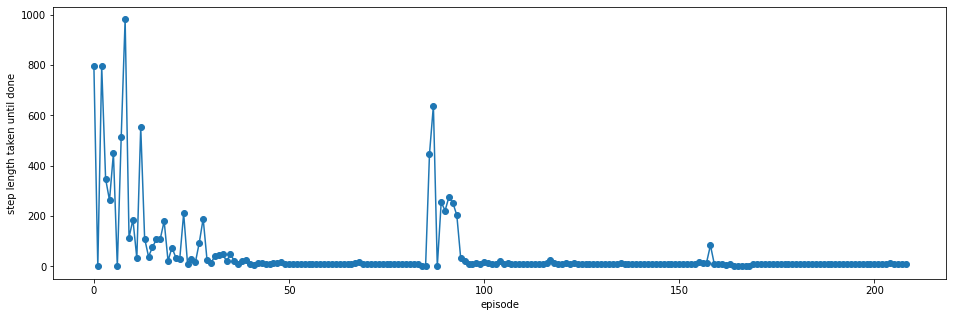

In [132]:
plt.figure(figsize=(16, 5))
plt.plot([len(re) for re in episodes_actions], marker='o')
plt.xlabel('episode')
plt.ylabel('step length taken until done')

Text(0, 0.5, 'step length taken until done')

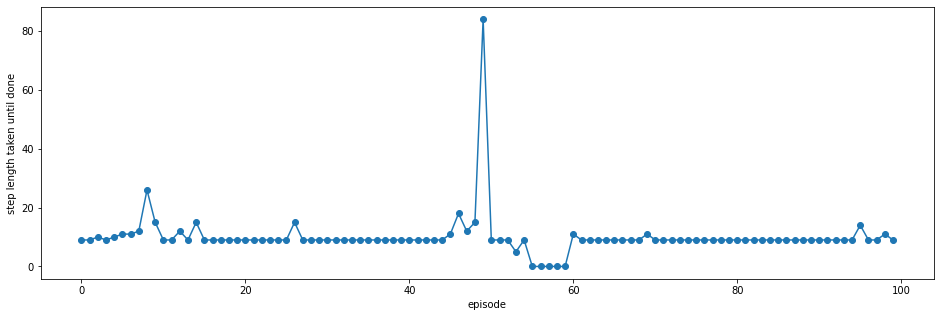

In [135]:
plt.figure(figsize=(16, 5))
plt.plot([len(re) for re in episodes_actions[-100:]], marker='o')
plt.xlabel('episode')
plt.ylabel('step length taken until done')

In [136]:
# エピソード1
episodes_actions[0]

[<JankenHand.CHOKI: 1>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand

In [137]:
# 最終エピソード
episodes_actions[-1]

[<JankenHand.GUU: 0>,
 <JankenHand.PAA: 2>,
 <JankenHand.GUU: 0>,
 <JankenHand.PAA: 2>,
 <JankenHand.GUU: 0>,
 <JankenHand.PAA: 2>,
 <JankenHand.PAA: 2>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>]